In [1]:
RANDOM_SEED = 0

import random

random.seed(RANDOM_SEED)

import torch

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.manual_seed_all(RANDOM_SEED)
else:
    device = "cpu"

import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

import numpy as np

np.random.seed(RANDOM_SEED)

import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to("cpu").detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, alpha=0.5, cmap="tab10")
        
        if i > num_batches:
            break
    
    plt.colorbar()
    plt.gca().set_aspect("equal")


def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.imshow(img, extent=[*r0, *r1])

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        print("epoch", epoch)

        pbar = tqdm(data)
        for x, y in data:
            x = x.to(device)
            
            opt.zero_grad()
            
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            
            loss.backward()
            opt.step()

            pbar.set_postfix({"recon loss": loss.item()})
            pbar.update()
        
        pbar.close()
    
    return autoencoder

In [23]:
data = torchvision.datasets.MNIST(
    '../data',
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(
    data, 
    [train_size, test_size], 
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

shuffled_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)
shuffled_train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

In [4]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

autoencoder = train(autoencoder, shuffled_data)

epoch 0


100%|█████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.49it/s, recon loss=3.83e+3]


epoch 1


100%|█████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.76it/s, recon loss=3.47e+3]


epoch 2


100%|█████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.02it/s, recon loss=3.38e+3]


epoch 3


100%|█████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.03it/s, recon loss=3.23e+3]


epoch 4


100%|█████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.08it/s, recon loss=3.25e+3]


epoch 5


100%|█████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 31.23it/s, recon loss=3.07e+3]


epoch 6


100%|█████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.96it/s, recon loss=3.16e+3]


epoch 7


100%|█████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.64it/s, recon loss=3.17e+3]


epoch 8


100%|█████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.66it/s, recon loss=3.16e+3]


epoch 9


100%|█████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 26.04it/s, recon loss=3.04e+3]


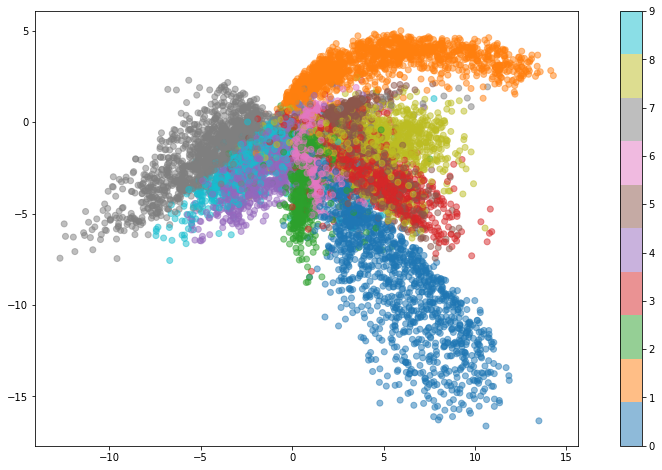

In [12]:
plt.figure(figsize=(15, 8))

plot_latent(autoencoder, data)

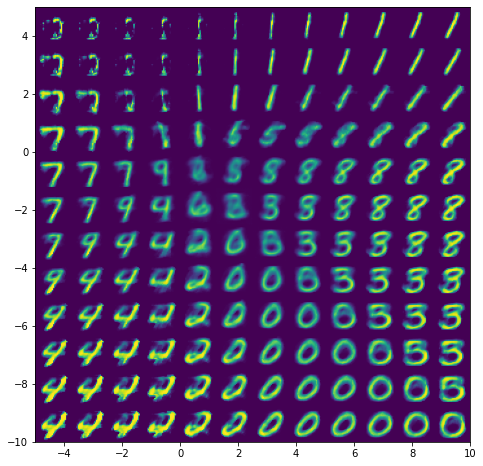

In [9]:
plt.figure(figsize=(8, 8))

plot_reconstructed(autoencoder)